# Soft Margin Support Vector Machine
___
See the code [here]().

## 1. Libraries

In [1]:
import os
import sys


# Adding the path to the algorithms modules
ROOT_PATH = os.path.join("..", "..", "algos", "basic")
sys.path.append(ROOT_PATH)

import torch
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from svm import SupportVectorMachine

## 2. Dataset

### 2.1. Generating the dataset

In [2]:
# Creating a mock dataset with sklearn
X, y = make_classification(
    n_samples=150,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=2,
    random_state=42
)
# Setting all 0s to 1s, since that's expected by the binary SVM algorithm.
y[y == 0] = -1

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (150, 2)
y shape: (150,)


### 2.2. Plotting the dataset

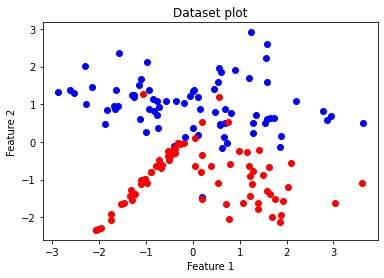

In [3]:
def plot_dataset(X, y, colors={-1: "red", 1: "blue"}, title="Dataset"):
    # Plot the two classes
    for i in range(len(y)):
        plt.scatter(X[i, 0], X[i, 1], color=colors[y[i]])

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


plot_dataset(X, y, title="Dataset plot")

## 3. Training and evaluation

### 3.1. Training

In [4]:
X, y = torch.Tensor(X), torch.Tensor(y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

print("Starting the training...")
print("Printing the loss for each 20 epochs.")
svm = SupportVectorMachine()
svm.fit(X_train, y_train, iters=40)

Starting the training...
Printing the loss for each 20 epochs.
Loss: 4.10
Loss: 0.10


### 3.2. Model Evaluation

In [5]:
eval_loss = svm.evaluate(X_valid, y_valid)
print(f"Evaluation loss: {eval_loss:.2f}")

torch.Size([30, 2]) torch.Size([3, 1])
Evaluation loss: 0.10


In [7]:
y_pred = svm.predict(X).squeeze(-1).detach().numpy()
print(y_pred)
plot_dataset(X, y_pred.round(), title="Predicted classes")

torch.Size([150, 3])
[0.06299993 0.04040655 0.04646794 0.053669   0.05765293 0.04879089
 0.05434649 0.05036549 0.06302421 0.04736057 0.05089856 0.04991405
 0.05310483 0.05258923 0.05674085 0.05677981 0.05609554 0.04977703
 0.05128291 0.04817399 0.04966421 0.04932096 0.05132815 0.04972716
 0.06187861 0.05025858 0.04759694 0.05690588 0.05060322 0.05197296
 0.05821539 0.05227226 0.06022665 0.05109617 0.05331981 0.05026534
 0.0494316  0.05128957 0.05454357 0.05722558 0.0392491  0.05317751
 0.04556813 0.03884979 0.05940537 0.05182303 0.05269474 0.04838665
 0.05030833 0.05922926 0.05027888 0.04536125 0.0511659  0.05027857
 0.05648838 0.05476956 0.05763504 0.04650616 0.04739076 0.04246107
 0.055101   0.0523997  0.05415333 0.04930747 0.05311151 0.05317949
 0.0492332  0.05469197 0.06008771 0.05530549 0.04339107 0.05163348
 0.05076826 0.05229028 0.05491215 0.05252146 0.04091403 0.04825264
 0.04363815 0.05201055 0.05134718 0.04499647 0.05463156 0.05408134
 0.06056335 0.05341842 0.04387122 0.03880

KeyError: 0.0